# object selection form catalog

currently it's just a simple selection S/N of Ha Hb fluxes > 5

# THis section of the code separately combines photometry, spectroscopy, Lmass, morphology & AGN catalog together, separately for GN GS fields.

/var/folders/4g/0323142n2td202rpvz2sx_n40000gn/T/ipykernel_13507/722533586.py:198: UserWarning: You passed a edgecolor/edgecolors ('red') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(agn_gs['RAdeg'][d2d_gs.arcsec<thresh],agn_gs['DEdeg'][d2d_gs.arcsec<thresh],s=100,alpha=0.5,color='red',label='good south crossmatch',marker='x',edgecolor='red')
/var/folders/4g/0323142n2td202rpvz2sx_n40000gn/T/ipykernel_13507/722533586.py:208: UserWarning: You passed a edgecolor/edgecolors ('orange') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(agn_gn['RAdeg'][d2d_gn.arcsec<thresh],agn_gn['DEdeg'][d2d_gn.arcsec<thresh],s=100,alpha=1,color='red',label='good north chandra catalog',marker='x',edgecolor='orange')


fraction of agn in full catalog: 0.03952843273231623


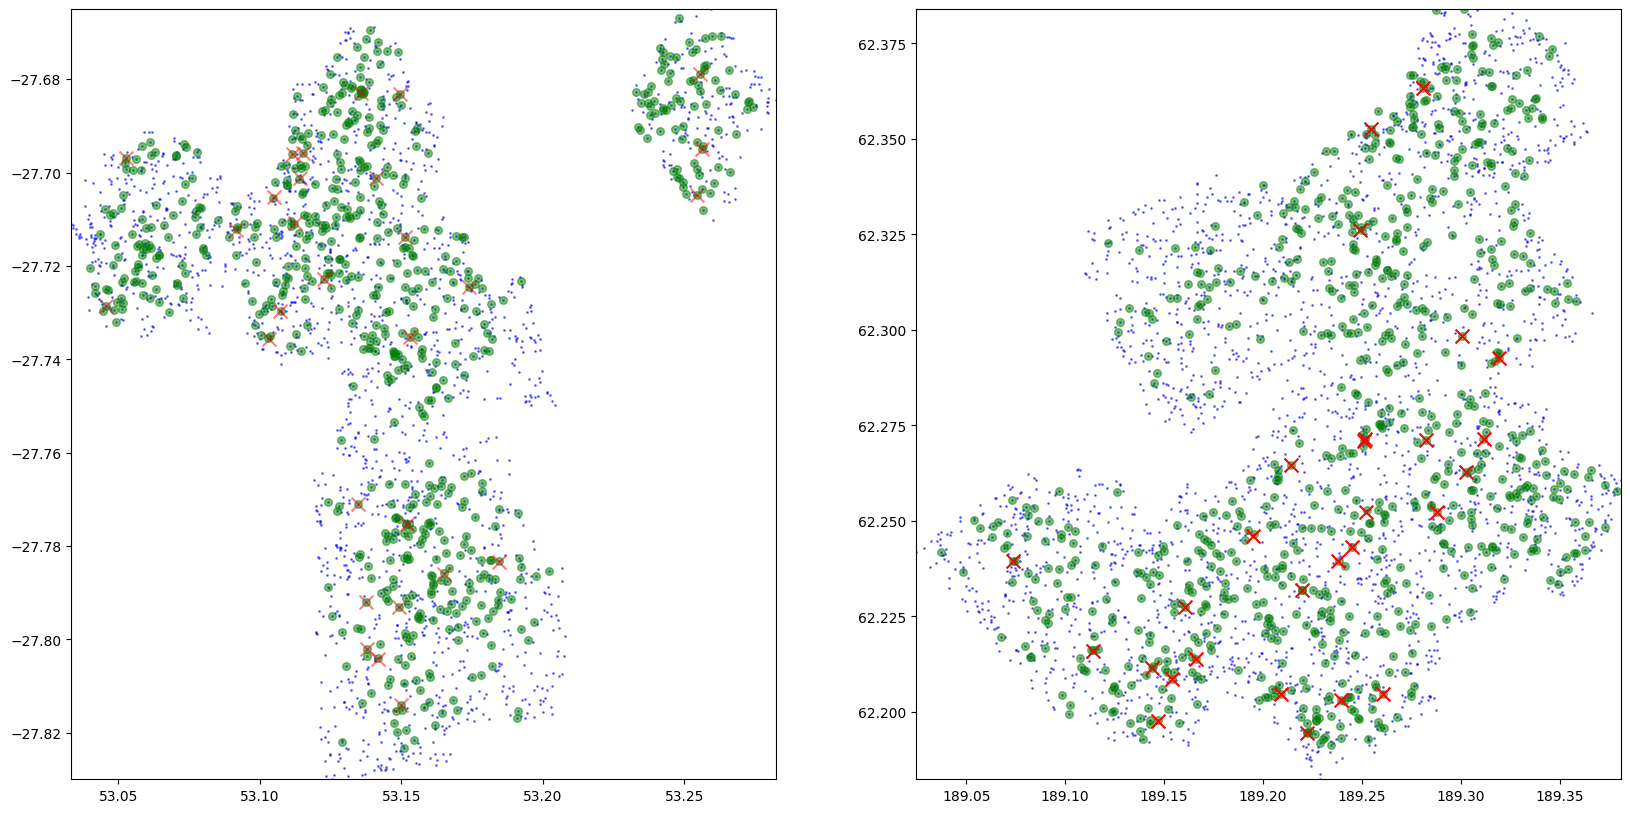

In [2]:
from   astropy.table        import Table, vstack, join, setdiff
from   scripts.tools        import *
import numpy                as     np
from   astropy.coordinates  import SkyCoord, match_coordinates_sky
import astropy.units        as     u
from   astropy.cosmology    import Planck18
import pandas               as     pd
# visualize id crossmatch
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import warnings
from   astropy.io.fits.card import VerifyWarning
warnings.simplefilter('ignore', VerifyWarning)


### CLEAR GoodsN+S sample prearation, stacking
# initial catalog
gn   = Table.read('hlsp_clear_hst_wfc3_gdn_multi_v4.1_clear.fits')
gn_m = Table.read('hlsp_clear_hst_wfc3-acs_gdn-3dhst_multi_v4.6_zout.fits')
gn_gal = Table.read('galfit/goodsn/goodsn_3dhst.v4.1_f125w.galfit',format='ascii')
gn_all = join(gn_m,gn_gal,keys_left='id',keys_right='NUMBER',join_type='left')
gn_cat = join(gn,gn_all,keys_left='ID',keys_right='id',join_type='left',metadata_conflicts='silent')
gn_cat['field'] = 'gn'



gs   = Table.read('hlsp_clear_hst_wfc3_gds_multi_v4.1_clear.fits')
gs_m = Table.read('hlsp_clear_hst_wfc3-acs_gds-3dhst_multi_v4.6_zout.fits')
gs_gal = Table.read('galfit/goodss/goodss_3dhst.v4.1_f125w.galfit',format='ascii')
gs_all = join(gs_m,gs_gal,keys_left='id',keys_right='NUMBER',join_type='left')
gs_cat = join(gs,gs_all,keys_left='ID',keys_right='id',join_type='left',metadata_conflicts='silent')
gs_cat['field'] = 'gs'

cat_lis = vstack([gn_cat,gs_cat],metadata_conflicts='silent')

#constrain positive redshift
z_real = cat_lis['z_MAP'] > 0
#constrain positive mass
mass_real = cat_lis['mass'] > 0
#constrain positive re
re_real = cat_lis['f'] <=  1
#constrain positie ha and hb
ha_real = cat_lis['Ha_FLUX'] > 0
hb_real = cat_lis['Hb_FLUX'] > 0

#calculate sn ratio
sn_ha = cat_lis['Ha_FLUX']/cat_lis['Ha_FLUX_ERR']
cat_lis['sn_ha'] = sn_ha
sn_hb = cat_lis['Hb_FLUX']/cat_lis['Hb_FLUX_ERR']
cat_lis['sn_hb'] = sn_hb


cat_lis = cat_lis[z_real & mass_real & re_real & ha_real & hb_real]

#positive crossmatch_threshold in arcsec
thresh =  2
#make 2 subplots
plt.figure(figsize=(20, 10))
### Chandra catalog preparation and cross match
#goodss xray catalog
column_specs_gs = [
    (0, 4), (5, 14), (15, 25), (26, 31), (32, 34), (35, 39), (40, 45), 
    (46, 53), (54, 59), (60, 65), (66, 73), (74, 79), (80, 85), (86, 93), 
    (94, 99), (100, 105), (106, 107), (108, 115), (116, 121), (122, 145), 
    (146, 155), (156, 166), (167, 172), (173, 182), (183, 193), (194, 199), 
    (200, 209), (210, 220), (221, 226), (227, 236), (237, 247), (248, 253), 
    (254, 263), (264, 274), (275, 280), (281, 290), (291, 301), (302, 307), 
    (308, 317), (318, 328), (329, 334), (335, 341), (342, 350), (351, 353), 
    (354, 359), (360, 365), (366, 371), (372, 377), (378, 383), (384, 389), 
    (390, 396), (397, 402), (403, 408), (409, 414), (415, 423), (424, 432), 
    (433, 441), (442, 448), (449, 455), (456, 462), (463, 468), (469, 474), 
    (475, 480), (481, 490), (491, 500), (501, 510), (511, 520), (521, 530), 
    (531, 540), (541, 547), (548, 551), (552, 555), (556, 560)
]
column_names_gs = [
    "XID", "RAdeg", "DEdeg", "logPB", "WAV", "PE", "Angle", "FB", "e_FB", "E_FB",
    "SB", "e_SB", "E_SB", "HB", "e_HB", "E_HB", "PNOTE", "CPCAT", "CPDIS", "CPNOTE",
    "WFI-RA", "WFI-DE", "WFImag", "GOODSS-RA", "GOODSS-DE", "GOODSSmag", 
    "GEMS-RA", "GEMS-DE", "GEMSmag", "CANDELS-RA", "CANDELS-DE", "CANDELSmag",
    "TENIS-RA", "TENIS-DE", "TENISmag", "SEDS-RA", "SEDS-DE", "SEDSmag",
    "VLA-RA", "VLA-DE", "VLAmag", "zSpec", "q_zSpec", "r_zSpec", "zL10", "zR11", 
    "zH14", "zS14", "zS15", "zS16", "zF", "r_zF", "e_zF", "E_zF", "FExp", "SExp", 
    "HExp", "BR", "e_BR", "E_BR", "Gamma", "e_Gamma", "E_Gamma", "FFB", "FSB",
    "FHB", "LX", "NH", "LXc", "OType", "X11ID", "X16ID", "R13ID"
]

chandra_gs = Table.from_pandas(
                pd.read_fwf('chandra_gs.txt', 
                            colspecs=column_specs_gs,  
                            names=column_names_gs,     
                            skiprows=174))

#goodsn xray catalog
column_specs_gn = [
    (0, 3), (4, 6), (7, 9), (10, 15), (16, 17), (17, 19), (20, 22), (23, 27),
    (28, 33), (34, 36), (37, 40), (41, 46), (47, 55), (56, 62), (63, 69), (70, 78),
    (79, 85), (86, 92), (93, 101), (102, 108), (109, 115), (116, 117), (118, 120),
    (121, 123), (124, 129), (130, 131), (131, 133), (134, 136), (137, 141), (142, 147),
    (148, 153), (154, 161), (162, 164), (165, 167), (168, 173), (174, 175), (175, 177),
    (178, 180), (181, 185), (186, 191), (192, 194), (195, 197), (198, 203), (204, 205),
    (205, 207), (208, 210), (211, 215), (216, 221), (222, 224), (225, 227), (228, 233),
    (234, 235), (235, 237), (238, 240), (241, 245), (246, 251), (252, 254), (255, 257),
    (258, 263), (264, 265), (265, 267), (268, 270), (271, 275), (276, 281), (282, 284),
    (285, 287), (288, 293), (294, 295), (295, 297), (298, 300), (301, 305), (306, 311),
    (312, 314), (315, 317), (318, 323), (324, 325), (325, 327), (328, 330), (331, 335),
    (336, 341), (342, 348), (349, 351), (352, 358), (359, 365), (366, 372), (373, 379),
    (380, 386), (387, 395), (396, 402), (403, 409), (410, 416), (417, 423), (424, 430),
    (431, 437), (438, 444), (445, 447), (448, 450), (451, 456), (457, 458), (458, 460),
    (461, 463), (464, 468), (469, 478), (479, 488), (489, 498), (499, 504), (505, 510),
    (511, 516), (517, 522), (523, 528), (529, 534), (535, 544), (545, 554), (555, 564),
    (565, 574), (575, 581), (582, 585)
]
column_names_gn = [
    "ID", "RAh", "RAm", "RAs", "DE-", "DEd", "DEm", "DEs", "Log(P)", "Log(Pm)",
    "PosErr", "OffAng", "FCts", "UFCts", "LFCts", "SCts", "USCts", "LSCts", "HCts",
    "UHCts", "LHCts", "Ifpsf", "CRAh", "CRAm", "CRAs", "CDE-", "CDEd", "CDEm",
    "CDEs", "C-XOff", "Cmag", "Ccat", "VRAh", "VRAm", "VRAs", "VDE-", "VDEd",
    "VDEm", "VDEs", "Vmag", "GDRAh", "GDRAm", "GDRAs", "GDDE-", "GDDEd", "GDDEm",
    "GDDEs", "GDmag", "CFRAh", "CFRAm", "CFRAs", "CFDE-", "CFDEd", "CFDEm", "CFDEs",
    "CFmag", "KsRAh", "KsRAm", "KsRAs", "KsDE-", "KsDEd", "KsDEm", "KsDEs", "Ksmag",
    "RRAh", "RRAm", "RRAs", "RDE-", "RDEd", "RDEm", "RDEs", "Rmag", "SRAh", "SRAm",
    "SRAs", "SDE-", "SDEd", "SDEm", "SDEs", "Smag", "zspec", "zref", "zphoty",
    "zphotyl", "zphotyu", "q_zphoty", "zphotya", "f_zphoty", "zphots", "zphotsl",
    "zphotsu", "q_zphots", "f_zphots", "zadopt", "A03", "A03RAh", "A03RAm", "A03RAs",
    "A03DE-", "A03DEd", "A03DEm", "A03DEs", "FExp", "SExp", "HExp", "BRat", "UBRat",
    "LBRat", "PInd", "UPInd", "LPInd", "FFlux", "SFlux", "HFlux", "Lx", "Type", "Notes"
]

chandra_gn = Table.from_pandas(
                pd.read_fwf('chandra_gn.txt', 
                            colspecs=column_specs_gn,  
                            names=column_names_gn,     
                            skiprows=217))


#here convert ra dec coordinates to degree
if True:
    
    # Extract RA and DEC columns from the Astropy table
    ra_h = chandra_gn['CFRAh']  # Hour of Right Ascension
    ra_m = chandra_gn['CFRAm']  # Minute of Right Ascension
    ra_s = chandra_gn['CFRAs']  # Second of Right Ascension
    dec_sign = chandra_gn['CFDE-']  # Sign of Declination
    dec_d = chandra_gn['CFDEd']  # Degree of Declination
    dec_m = chandra_gn['CFDEm']  # Arcminute of Declination
    dec_s = chandra_gn['CFDEs']  # Arcsecond of Declination
    '''
    #try anothere ra dec
    ra_h = chandra_gn['RAh']  # Hour of Right Ascension
    ra_m = chandra_gn['RAm']  # Minute of Right Ascension
    ra_s = chandra_gn['RAs']  # Second of Right Ascension
    dec_sign = chandra_gn['DE-']  # Sign of Declination
    dec_d = chandra_gn['DEd']  # Degree of Declination
    dec_m = chandra_gn['DEm']  # Arcminute of Declination
    dec_s = chandra_gn['DEs']  # Arcsecond of Declination
    '''

    # Convert RA to degrees using scipy vectorization
    ra_deg = 15 * (np.add(ra_h, np.add(ra_m / 60, ra_s / 3600)))  # Convert RA to degrees (1 hour = 15 degrees)
    # Convert DEC to degrees based on the sign using scipy functions
    dec_deg = np.add(dec_d, np.add(dec_m / 60, dec_s / 3600))  # Convert Declination to degrees
    dec_deg = np.where(dec_sign == '-', -dec_deg, dec_deg)  # Apply the sign to Declination

    # Add converted RA and DEC in degrees to the table
    chandra_gn['RAdeg'] = ra_deg  # Right Ascension in degrees
    chandra_gn['DEdeg'] = dec_deg  # Declination in degrees


#now cross match xray catalog
coord_obj  = SkyCoord(cat_lis['ra'],cat_lis['dec'],unit=(u.deg,u.deg))

#goodss agn crossmatch
agn_gs      = chandra_gs[chandra_gs['OType']=='AGN']
coord_chan_gs = SkyCoord(
                      agn_gs['RAdeg'],
                      agn_gs['DEdeg'],
                      unit=(u.deg, u.deg))
idx_gs,d2d_gs,d3d_gs = match_coordinates_sky(coord_chan_gs,coord_obj)

#goodsn agn catalog
agn_gn      = chandra_gn[chandra_gn['Type']=='AGN']
#agn_mask_gn = chandra_gn['Type'] != 'ddf'
coord_chan_gn = SkyCoord(
                      agn_gn['RAdeg'],
                      agn_gn['DEdeg'],
                      unit=(u.deg, u.deg))
idx_gn,d2d_gn,d3d_gn = match_coordinates_sky(coord_chan_gn,coord_obj)

#make first subplot
plt.subplot(121)
#do the same for good south
plt.scatter(gs_cat['ra'],gs_cat['dec'],s=1,alpha=0.5,color='blue',label='good south')
gs_mask = cat_lis['field'] == 'gs'
plt.scatter(cat_lis['ra'][gs_mask],cat_lis['dec'][gs_mask],s=30,alpha=0.5,color='green',label='ha,hb flux>0',)
#plot the chandra catalog
plt.scatter(agn_gs['RAdeg'][d2d_gs.arcsec<thresh],agn_gs['DEdeg'][d2d_gs.arcsec<thresh],s=100,alpha=0.5,color='red',label='good south crossmatch',marker='x',edgecolor='red')
plt.xlim(np.min(gs_cat['ra']),np.max(gs_cat['ra']))
plt.ylim(np.min(gs_cat['dec']),np.max(gs_cat['dec']))
#make second subplot
plt.subplot(122)
#plot good north and its crossmatch only
plt.scatter(gn_cat['ra'],gn_cat['dec'],s=1,alpha=0.5,color='blue',label='good north')

gn_mask = cat_lis['field'] == 'gn'
plt.scatter(cat_lis['ra'][gn_mask],cat_lis['dec'][gn_mask],s=30,alpha=0.5,color='green',label='ha,hb flux>0',)
plt.scatter(agn_gn['RAdeg'][d2d_gn.arcsec<thresh],agn_gn['DEdeg'][d2d_gn.arcsec<thresh],s=100,alpha=1,color='red',label='good north chandra catalog',marker='x',edgecolor='orange')
plt.xlim(np.min(gn_cat['ra']),np.max(gn_cat['ra']))
plt.ylim(np.min(gn_cat['dec']),np.max(gn_cat['dec']))

#matching the coordinates
#thresh for positive crossmatching in arcsec

id_matched = np.append(idx_gs[d2d_gs.arcsec < thresh],idx_gn[d2d_gn.arcsec < thresh])
cat_lis['tag'] = ['agn' if index in id_matched else 'gxy' for index in range(len(cat_lis))]
cat_lis.write('full_object_catalog.fits',overwrite=True)
print('fraction of agn in full catalog:',len(cat_lis[cat_lis['tag']=='agn'])/len(cat_lis))

### s/n and manual selection

total num of objs with positive ha;hb fluxes 1442
num of objs after s/n selection: 336
num of obj after agn selection 310
num of obj after manual and agn selection 286


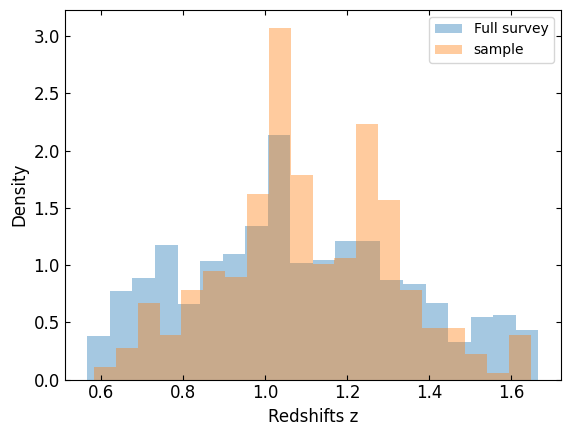

<Figure size 500x500 with 0 Axes>

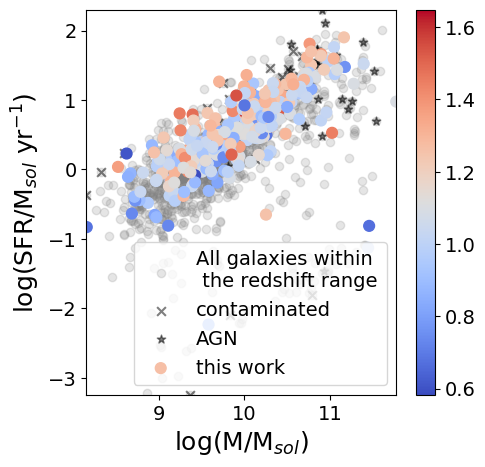

In [3]:
cat_hasline = cat_lis[np.logical_and(cat_lis['Ha_FLUX'] >0, cat_lis['Hb_FLUX']>0)]
sn_ha = cat_hasline['Ha_FLUX']/cat_hasline['Ha_FLUX_ERR']
cat_hasline['sn_ha'] = sn_ha
sn_hb = cat_hasline['Hb_FLUX']/cat_hasline['Hb_FLUX_ERR']
cat_hasline['sn_hb'] = sn_hb

selection = np.logical_and(sn_ha>3,sn_hb>3)

obj_lis = cat_hasline[selection]

manual_selection = np.array((
    ['ERSPRIME',40759],
    ['ERSPRIME',43823],
    ['ERSPRIME',45646],
    ['GN1',37031],
    ['GN1',37913],
    ['GN1',37395],
    ['GN1',37623],
    ['GN1',37738],
    ['GN1',38134],
    ['GN2', 11228],
    ['GN2', 14895],
    ['GN2', 14895],
    #['GN2', 16752],
    ['GN2', 17579],
    ['GN2', 17829],
    ['GN2', 18197],
    ['GN2', 18224],
    ['GN2', 18315],
    ['GN2', 21552],
    #['GN3', 28121],
    ['GN3', 30204],
    ['GN3', 32166],
    ['GN3', 32660],
    ['GN3', 34570],
    ['GN3', 34708],
    ['GN3', 34838],
    ['GN3', 35042],
    ['GN3', 35568],
    ['GN3', 35822],
    ['GN3', 19075],
    ['GN3', 28121],
    #['GN4', 21690],
    ['GN4', 24377],
    #['GN4', 24582],
    ['GN4', 26015],
    #['GN4', 28379],
    ['GN4', 27282],
    ['GN5', 31789],
    ['GN7', 12769],
    #['GN7', 13909],
    ['GN7', 13197],
    #['GN7', 13777],
    #['GN7', 14281],
    ['GN7', 14716],
    #['GN7', 14184],
    #['GN7', 14850],
    ['GN7', 15127],
    ['GN7', 15204],
    ['GN7', 15300],
    ['GN7', 17352],
    ['GN7', 17532],
    ['GN7', 22746],
    ['GN7', 19504],
    ['GN7', 23580],
    ['GS1', 45789],
    ['GS1', 47214],
    #['GS1', 47399],
    ['GS1', 47375],
    ['GS1', 48850],
    #['GS2', 48123],
    ['GS1', 49063],
    #['GS1', 36182],
    ['GS2', 45633],
    ['GS2', 46564],
    ['GS2', 47770],
    ['GS2', 45795],
    #['GS3', 37010],
    ['GS2', 48652],
    ['GS3', 34363],
    ['GS3', 37903],
    ['GS3', 40611],
    ['GS3', 41370],
    ['GS4', 20698],
    ['GS4', 24803],
    ['GS4', 25452],
    ['GS4', 24947],
    ['GS4', 25641],
    #['GS4', 25745],
    ['GS4', 25592],
    ['GS4', 26739],
    ['GS4', 29686],
    ['GS4', 20970],
    ['GS2', 46564],
    #['GS4', 22730],
    ['GS4', 26175],
    #['GS4', 26807],
    ['GS4', 29717],
    ['GS4', 29846],
    ['GS4', 29394],
    ['GS4', 28190],
    ['GS4', 30976],
    ['GS4', 31454],
    ['GS5', 38513],
    ['GS4', 20976],
    ['GS5', 41122],
    #['GS5', 44066],
    #['GS5', 40976],
    #['GS5', 44519],
    ['GS5', 42758],
    #['GS5', 42472],\
    ['GN2', 16867],
    ['GN7', 17024],
    ['GN7', 17190],
    ['GN2', 17194],
    ['GN7', 17216],
    ['GN2', 17204],
    ['GN2', 17139],
    ['ERSPRIME', 39689],
    ['GS3', 39619],
    ['GS3', 40042],
    ['GS5', 40306],
    ['GS3', 40334],
    ['GS5', 40811],
    ['GS5', 40774],
    ['GS3', 41261],
    ['ERSPRIME', 41688],
    ['GS5', 41923],
    ['ERSPRIME', 42139]
))

is_selected = np.isin(obj_lis['ID'],manual_selection[:,1]) & np.isin(obj_lis['subfield'],manual_selection[:,0])
obj_lis['manual_select'] = np.where(is_selected,'selected','keep') 
obj_lis['pixel_length']  =  np.deg2rad(0.1/3600) * Planck18.angular_diameter_distance(obj_lis['z_MAP']).to(u.kpc).value

mask = (obj_lis['f'] <= 1) & (obj_lis['mass'] > 0) & (obj_lis['re'] > 0)
obj_lis = obj_lis[mask]


obj_lis.write('obj_lis_selected.fits',overwrite=True)

print('total num of objs with positive ha;hb fluxes',len(cat_lis))
print('num of objs after s/n selection:',len(obj_lis))
print('num of obj after agn selection',len(obj_lis[obj_lis['tag']!='agn']))
print('num of obj after manual and agn selection',len(obj_lis[obj_lis['manual_select']!='selected']))


### redshift of selected objs
full_object_list = Table.read('full_object_catalog.fits')
obj_with_line = full_object_list[np.logical_and(full_object_list['Ha_FLUX']>0,full_object_list['Hb_FLUX']>0)]

plt.hist(obj_with_line['z_MAP'],bins=20,alpha=0.4,density=True,label='Full survey')
plt.hist(obj_lis['z_MAP'],bins=20,alpha=0.4,density=True,label='sample')
plt.xlabel('Redshifts z',fontsize=12)
plt.ylabel('Density',fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12, direction='in', top=True, right=True)
plt.legend()
plt.savefig('image_outputs/redshift_distribution.jpg',transparent=False)

### SFMS of selected objects
from scripts.sfms import *

logmass = np.log10(obj_lis['mass'])
logsfr  = np.log10(obj_lis['sfr'])
agn     = obj_lis['tag'] == 'agn'
contam  = np.logical_and(obj_lis['manual_select'] == 'selected', np.logical_not(agn))
sample  = np.logical_and(np.logical_not(agn), np.logical_not(contam))

plt.figure(figsize=(5, 5))

# 使用颜色映射
cmap = plt.get_cmap('coolwarm')  # 更换为深色的颜色映射
norm = plt.Normalize(vmin=np.min(obj_lis['z_MAP']), vmax=np.max(obj_lis['z_MAP']))

fig, ax = plt.subplots(figsize=(5, 5))

full_cat = Table.read('full_object_catalog.fits')
mask  = np.logical_and(full_cat['z_MAP'] > np.min(obj_lis['z_MAP']), full_cat['z_MAP'] < np.max(obj_lis['z_MAP']))
full_cat = full_cat[mask]
ax.scatter(np.log10(full_cat['mass']),
            np.log10(full_cat['sfr']),
            color='grey', alpha=0.2, label='All galaxies within \n the redshift range')
ax.scatter(logmass[contam], logsfr[contam], color='black', marker='x', label='contaminated', s=40, alpha=0.5)
ax.scatter(logmass[agn], logsfr[agn], color='black', marker='*', label='AGN', s=40, alpha=0.5)
sc = ax.scatter(logmass[sample], logsfr[sample], c=obj_lis['z_MAP'][sample], cmap=cmap, norm=norm, label='this work', s=60)

ax.set_xlim(np.nanmin(logmass), np.nanmax(logmass))
ax.set_ylim(np.nanmin(logsfr), np.nanmax(logsfr))

m_model, sfr_1_l, sfr_1_h, sfr_2_l, sfr_2_h = SFMS_model(np.nanmin(logmass), np.nanmax(logmass))
#ax.fill_between(m_model, sfr_1_l, sfr_1_h, color="r", alpha=0.2, label='SFMS 1.0<z<1.5')
#ax.fill_between(m_model, sfr_2_l, sfr_2_h, color="b", alpha=0.2, label='SFMS 0.5<z<1.0')

ax.legend(fontsize=14, loc='lower right')
ax.set_xlabel(r'log(M/M$_{sol}$)', fontsize=18)
ax.set_ylabel(r'log(SFR/M$_{sol}$ yr$^{-1}$)', fontsize=18)
#ax.set_title('Star Formation Main Sequence', fontsize=20)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

# 添加颜色条
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
#cbar.set_label('Redshift (z)', fontsize=18)
cbar.ax.tick_params(labelsize=14)
plt.savefig('image_outputs/sfms.jpg',dpi=300)
plt.show()



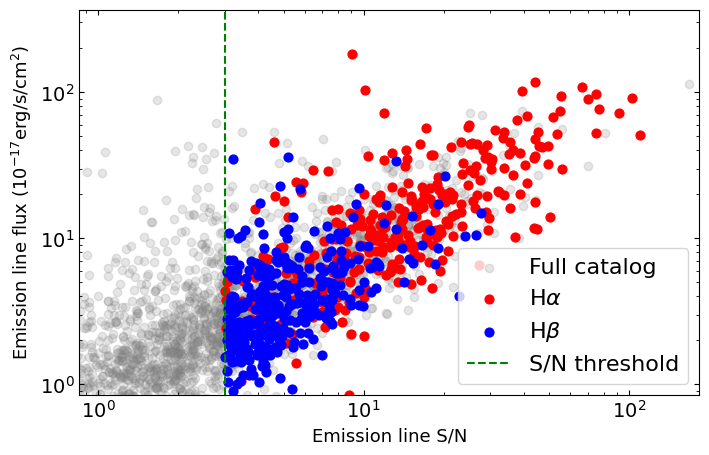

In [148]:
line_flux_ha = obj_lis['Ha_FLUX']
line_flux_hb = obj_lis['Hb_FLUX']
sn_ha = obj_lis['sn_ha']
sn_hb = obj_lis['sn_hb']
full_cat_sn_ha = full_object_list['Ha_FLUX']/full_object_list['Ha_FLUX_ERR']
full_cat_sn_hb = full_object_list['Hb_FLUX']/full_object_list['Hb_FLUX_ERR']

plt.figure(figsize=(8, 5))

plt.scatter(full_cat_sn_ha, full_object_list['Ha_FLUX'], color='grey', alpha=0.2, label='Full catalog')
plt.scatter(full_cat_sn_hb, full_object_list['Hb_FLUX'], color='grey', alpha=0.2)
plt.scatter(sn_ha, line_flux_ha, color='r', s=40, label=r'H$\alpha$')
plt.scatter(sn_hb, line_flux_hb, color='b', s=40, label=r'H$\beta$')

plt.axvline(x=3, color='green', linestyle='--', label='S/N threshold')

plt.xscale('log')
plt.yscale('log')
plt.xlim(np.nanmin(line_flux_ha), np.nanmax(line_flux_ha))
plt.ylim(np.nanmin(line_flux_ha), np.nanmax(line_flux_ha)*2)
plt.xlabel('Emission line S/N', fontsize=13)
plt.ylabel(r'Emission line flux ($10^{-17}$erg/s/cm$^2$)', fontsize=13)
plt.legend(fontsize=16)

# 设置刻度线朝内
plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('image_outputs/sn_line_flux.jpg', dpi=300)
plt.show()

In [158]:
obj_lis

ID,RA_1,DEC_1,nlines,z_50,z_02,z_16,z_84,z_97,z_MAP,z_RISK,ArIII-7138_FLUX,ArIII-7138_FLUX_ERR,ArIII-7138_EW_RF_16,ArIII-7138_EW_RF_50,ArIII-7138_EW_RF_84,CIII-1908_FLUX,CIII-1908_FLUX_ERR,CIII-1908_EW_RF_16,CIII-1908_EW_RF_50,CIII-1908_EW_RF_84,CIV-1549_FLUX,CIV-1549_FLUX_ERR,CIV-1549_EW_RF_16,CIV-1549_EW_RF_50,CIV-1549_EW_RF_84,H8_FLUX,H8_FLUX_ERR,H8_EW_RF_16,H8_EW_RF_50,H8_EW_RF_84,H9_FLUX,H9_FLUX_ERR,H9_EW_RF_16,H9_EW_RF_50,H9_EW_RF_84,Ha_FLUX,Ha_FLUX_ERR,Ha_EW_RF_16,Ha_EW_RF_50,Ha_EW_RF_84,Hb_FLUX,Hb_FLUX_ERR,Hb_EW_RF_16,Hb_EW_RF_50,Hb_EW_RF_84,Hd_FLUX,Hd_FLUX_ERR,Hd_EW_RF_16,Hd_EW_RF_50,Hd_EW_RF_84,HeI-1083_FLUX,HeI-1083_FLUX_ERR,HeI-1083_EW_RF_16,HeI-1083_EW_RF_50,HeI-1083_EW_RF_84,HeI-5877_FLUX,HeI-5877_FLUX_ERR,HeI-5877_EW_RF_16,HeI-5877_EW_RF_50,HeI-5877_EW_RF_84,HeII-1640_FLUX,HeII-1640_FLUX_ERR,HeII-1640_EW_RF_16,HeII-1640_EW_RF_50,HeII-1640_EW_RF_84,Hg_FLUX,Hg_FLUX_ERR,Hg_EW_RF_16,Hg_EW_RF_50,Hg_EW_RF_84,Lya_FLUX,Lya_FLUX_ERR,Lya_EW_RF_16,Lya_EW_RF_50,Lya_EW_RF_84,MgII_FLUX,MgII_FLUX_ERR,MgII_EW_RF_16,MgII_EW_RF_50,MgII_EW_RF_84,NIII-1750_FLUX,NIII-1750_FLUX_ERR,NIII-1750_EW_RF_16,NIII-1750_EW_RF_50,NIII-1750_EW_RF_84,NIV-1487_FLUX,NIV-1487_FLUX_ERR,NIV-1487_EW_RF_16,NIV-1487_EW_RF_50,NIV-1487_EW_RF_84,NV-1240_FLUX,NV-1240_FLUX_ERR,NV-1240_EW_RF_16,NV-1240_EW_RF_50,NV-1240_EW_RF_84,NeIII-3867_FLUX,NeIII-3867_FLUX_ERR,NeIII-3867_EW_RF_16,NeIII-3867_EW_RF_50,NeIII-3867_EW_RF_84,NeV-3346_FLUX,NeV-3346_FLUX_ERR,NeV-3346_EW_RF_16,NeV-3346_EW_RF_50,NeV-3346_EW_RF_84,NeVI-3426_FLUX,NeVI-3426_FLUX_ERR,NeVI-3426_EW_RF_16,NeVI-3426_EW_RF_50,NeVI-3426_EW_RF_84,OI-6302_FLUX,OI-6302_FLUX_ERR,OI-6302_EW_RF_16,OI-6302_EW_RF_50,OI-6302_EW_RF_84,OII_FLUX,OII_FLUX_ERR,OII_EW_RF_16,OII_EW_RF_50,OII_EW_RF_84,OII-7325_FLUX,OII-7325_FLUX_ERR,OII-7325_EW_RF_16,OII-7325_EW_RF_50,OII-7325_EW_RF_84,OIII_FLUX,OIII_FLUX_ERR,OIII_EW_RF_16,OIII_EW_RF_50,OIII_EW_RF_84,OIII-1663_FLUX,OIII-1663_FLUX_ERR,OIII-1663_EW_RF_16,OIII-1663_EW_RF_50,OIII-1663_EW_RF_84,OIII-4363_FLUX,OIII-4363_FLUX_ERR,OIII-4363_EW_RF_16,OIII-4363_EW_RF_50,OIII-4363_EW_RF_84,PaB_FLUX,PaB_FLUX_ERR,PaB_EW_RF_16,PaB_EW_RF_50,PaB_EW_RF_84,SII_FLUX,SII_FLUX_ERR,SII_EW_RF_16,SII_EW_RF_50,SII_EW_RF_84,SIII_FLUX,SIII_FLUX_ERR,SIII_EW_RF_16,SIII_EW_RF_50,SIII_EW_RF_84,HeII-4687_FLUX,HeII-4687_FLUX_ERR,HeII-4687_EW_RF_16,HeII-4687_EW_RF_50,HeII-4687_EW_RF_84,T_G102,T_G141,BIC_TEMP,CHIMIN,DOF,subfield,id,ra,dec,z_spec,nusefilt,lc_min,lc_max,z_phot,z_phot_chi2,z_phot_risk,z_min_risk,min_risk,z_raw_chi2,raw_chi2,z025,z160,z500,z840,z975,restU,restU_err,restB,restB_err,restV,restV_err,restJ,restJ_err,dL,mass,sfr,Lv,LIR,MLv,Av,mass_p,sfr_p,Lv_p,LIR_p,ssfr_p,rest270,rest270_err,rest274,rest274_err,rest120,rest120_err,rest121,rest121_err,rest156,rest156_err,rest157,rest157_err,rest158,rest158_err,rest159,rest159_err,rest160,rest160_err,rest161,rest161_err,rest162,rest162_err,rest163,rest163_err,DISTMOD,ABSM_271,ABSM_272,ABSM_274,NUMBER,RA_2,DEC_2,f,mag,dmag,re,dre,n,dn,q,dq,pa,dpa,sn,field,sn_ha,sn_hb,tag,manual_select,pixel_length
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,Mpc,solMass,solMass / yr,solLum,solLum,solMass / solLum,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,flo

# download spectrum from server.

It is recommended that to run the script downloadSpectra in prompt because of potential stability issue

# Extract line maps from data products

In [11]:
from    astropy.table       import Table
import  numpy               as     np
from    astropy.io          import fits
from    tqdm                import tqdm
import  os
import  gc       
import  re


def extract_HaHb(hdu):


    """

    pass objs from obj_lis to extract ha hb lines

    return: HDUlist with the following entry:

    0 primary extension, same as original file

    1 line-fit results

    2 segmentation map

    3 clear filter maps

    4,5 Ha line map & line weight

    6,7 Hb line map & line weight

    """
    #set up a crop of 50x50 pix in the center
    center_size = 50; shape = hdu[5].shape[0]
    #start index: si and end index: ei
    si = (shape - center_size) // 2; 
    ei = si + center_size

    new_file = fits.HDUList()
    #save primary extension
    new_file.append(hdu[0])
    #save line-fit info
    new_file.append(hdu[1])
    """
    select segmentation map [4]
    also save 1 DSCI image for comparison [5]
    """
    for i in [4,5]: 
        hdu[i].data = hdu[i].data[si:ei,si:ei]
        new_file.append(hdu[i])

    #loop to select ha hb line maps
    for image in hdu:
        if image.header.get('EXTTYPE') in ['Ha','Hb'] and (image.name == 'LINE' or image.name == 'LINEWHT'):
            image.data = image.data[si:ei,si:ei]
            image.name = f"{image.name}_{image.header['EXTTYPE']}"
            new_file.append(image)
    return new_file


def data_process(obj):
    if os.path.exists(f"data_extracted/{file_name(obj,'extracted')}"):
        return f"{obj['subfield']}-{obj['ID']} already exists"
    try:
        path_data_product   = f"data_products/{file_name(obj,'full')}"
        path_data_extracted = f"data_extracted/{file_name(obj,'extracted')}"

        need_update_from_data_products = True
        need_save_file = True

        with fits.open(path_data_product) as hdu:
            extracted = extract_HaHb(hdu)
            #save file
            extracted.writeto(path_data_extracted,overwrite=True)
        return f"{obj['subfield']}-{obj['ID']} saved"
    
    except Exception as e:
        return f"! {obj['subfield']}-{obj['ID']} failed, error:{e}"


from concurrent.futures import ThreadPoolExecutor, as_completed
def main():
    os.makedirs('data_extracted',exist_ok=True)
    obj_lis = Table.read('obj_lis_selected.fits')
    results = []
    max_threads= 15
    if max_threads > 1:
        with ThreadPoolExecutor(max_threads) as executor:
            futures = {executor.submit(data_process,obj):obj for obj in obj_lis}
            for future in tqdm(as_completed(futures), total=len(obj_lis), desc="Processing"):
                results.append(future.result())
    else: 
        for obj in tqdm(obj_lis):
            results.append(data_process(obj))
    number = 0
    error_table = Table(names=['subfield', 'ID', 'error'], dtype=['str', 'str', 'str'])
    for result in results:
        if 'error' in result:
            number += 1
            # 用正则提取
            m = re.match(r"! ([^-]+)-([^\s]+) failed, error:(.*)", result)
            if m:
                subfield, id_, error = m.group(1), m.group(2), m.group(3)
            else:
                subfield, id_, error = '', '', result
            error_table.add_row([subfield, id_, error])
            print(result)
    error_table.write('failed_objects.fits', overwrite=True)
    print('total number of obj processed:', len(results))
    print('number of failed obj', number)

if __name__ == '__main__':
    main()


Processing: 100%|██████████| 1025/1025 [00:00<00:00, 15240.98it/s]

! GS4-25452 failed, error:list index out of range
total number of obj processed: 1025
number of failed obj 1


In [12]:
error_table = Table.read('failed_objects.fits')
error_table


subfield,ID,error
bytes3,bytes5,bytes23
GS4,25452,list index out of range


In [13]:

#remove error objects from obj_lis
obj_lis = Table.read('obj_lis_selected.fits')
print(len(obj_lis))
obj_lis.remove_rows(np.where((obj_lis['subfield'] == 'GS4') & (obj_lis['ID'] == 25452))[0][0])
obj_lis.write('obj_lis_selected.fits',overwrite=True)

1025


In [14]:
for row in error_table:
    print(f"[\'{row['subfield']}\', {row['ID']}],")

['GS4', 25452],


In [15]:
#here we apply a correction of Nii for Ha +[NII] linemap
# #using Andreas L. Faisst 2018
def nii_ha_ratio(stellar_mass, redshift):
    """
    Calculate the [NII]/Hα flux ratio based on the empirical model by Faisst et al. (2018).
    
    Parameters:
    stellar_mass (float): Stellar mass of the galaxy (in solar masses)
    redshift (float): Redshift (z)
    
    Returns:
    float: Computed [NII]/Hα flux ratio
    """
    import numpy as np

    # Compute the scaled variables
    x = np.log10(stellar_mass) - 10.5
    y = redshift - 2.3

    # Apply the empirical relation
    log_nii_ha = -0.773 + 1.235 * x - 0.281 * x**2 - 0.020 * y + 0.019 * y**2

    # Convert log value to actual ratio
    return 10**log_nii_ha  


def nii_ha_ratio_zahid(stellar_mass, redshift):
    """
    Calculate the [NII]/Hα flux ratio based on the redshift-dependent empirical model by Zahid et al. (2014).

    Parameters:
    stellar_mass (float): Stellar mass of the galaxy (in solar masses)
    redshift (float): Redshift (z)

    Returns:
    float: Computed [NII]/Hα flux ratio
    """
    import numpy as np

    # Convert stellar mass to log scale
    logm = np.log10(stellar_mass)

    # Compute the redshift-dependent coefficient
    a_z = -1.32 + 0.4 * redshift

    # Apply Zahid et al. (2014) empirical relation
    log_nii_ha = a_z + 0.32 * (logm - 10) - 0.05 * (logm - 10)**2

    # Convert log value to actual ratio
    return 10**log_nii_ha



def NII_corr(obj):
    try:
        path = f"data_extracted/{file_name(obj,prefix='extracted')}"
        with fits.open(path,mode='update') as hdu:
            ha = find_data('LINE_HA',hdu)[1]
            if 'NII_corr' in ha.header:
                return f"{obj['subfield']}-{obj['ID']} already corrected"
            ha.name = 'LINE_HA'
            ratio = nii_ha_ratio_zahid(obj['mass'],obj['z_MAP'])
            ha.data = ha.data/(1+ratio)
            ha.header['NII_corr'] = str(round(ratio,8))
            save_update(ha,hdu)
            hdu.flush()
            return f"{obj['subfield']}-{obj['ID']} processed"
    except Exception as e:
        return f"! {obj['subfield']}-{obj['ID']} failed, error:{e}"

from    concurrent.futures  import ThreadPoolExecutor, as_completed
from    tqdm                import tqdm
def cat_process(obj_lis, max_threads=1):
        results = []
        if max_threads > 1 :
            with ThreadPoolExecutor(max_threads) as executor:
                futures = {executor.submit(
                    NII_corr,
                    obj): obj for obj in obj_lis}
                for future in tqdm(as_completed(futures), total=len(obj_lis), desc="Processing"):
                    results.append(future.result())
            return results
        else:
            for obj in tqdm(obj_lis):
                results.append(NII_corr(obj))
            return results

def main():
    obj_lis = Table.read('obj_lis_selected.fits')
    results = cat_process(obj_lis,max_threads=16)
    error_table = Table(names=['subfield', 'ID', 'error'], dtype=['str', 'str', 'str'])
    for result in results:
        number = 0
        if 'error' in result:
            number += 1

            m = re.match(r"! ([^-]+)-([^\s]+) failed, error:(.*)", result)
            if m:
                subfield, id_, error = m.group(1), m.group(2), m.group(3)
            else:
                subfield, id_, error = '', '', result
            error_table.add_row([subfield, id_, error])
            print(result)
    error_table.write('failed_objects.fits', overwrite=True)
    errorcounting(results)
    print(results)

if __name__ == '__main__':
    main()


Processing: 100%|██████████| 1024/1024 [00:32<00:00, 31.29it/s]


! GN7-17024 failed, error:'NoneType' object is not subscriptable
! GN7-17216 failed, error:'NoneType' object is not subscriptable
! GN7-17190 failed, error:'NoneType' object is not subscriptable
! GN2-17194 failed, error:'NoneType' object is not subscriptable
! GN2-16867 failed, error:'NoneType' object is not subscriptable
! GN2-17204 failed, error:'NoneType' object is not subscriptable
! GN2-17139 failed, error:buffer is too small for requested array
! GS3-39619 failed, error:'NoneType' object is not subscriptable
! ERSPRIME-39689 failed, error:'NoneType' object is not subscriptable
! GS3-40042 failed, error:'NoneType' object is not subscriptable
! GS5-40306 failed, error:'NoneType' object is not subscriptable
! GS3-40334 failed, error:'NoneType' object is not subscriptable
! GS5-40811 failed, error:'NoneType' object is not subscriptable
! GS5-40774 failed, error:'NoneType' object is not subscriptable
! GS3-41261 failed, error:'NoneType' object is not subscriptable
! ERSPRIME-41688 fa

In [17]:
obj_lis = Table.read('obj_lis_selected.fits')
print(len(obj_lis))
for row in obj_lis:
    if row['manual_select'] == 'selected':
        #remove the row from the table
        obj_lis.remove_row(np.where((obj_lis['subfield'] == row['subfield']) & (obj_lis['ID'] == row['ID']))[0][0])
obj_lis.write('obj_lis_selected_removed.fits', overwrite=True)
print('number of obj after manual and agn selection', len(obj_lis))

1024
number of obj after manual and agn selection 943
